## Set-up

In [2]:

import os
# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["HYDRA_FULL_ERROR"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
import subprocess
import pandas as pd
import math
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline
from scipy.spatial import ConvexHull

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## Path enviroment
- Take care of the sam2_checkpoint path. All the sam2 file are stored in /home/ipd/CV_Models/sam2
- Edit the file path of the video you use.
- For each video there will be a directory called "input_video_name + project_name" to store all the result.

In [ ]:
sam2_checkpoint = "/home/ipd/CV_Models/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

# TODO: change the project name and input video name
frame_rate = "1_15"  
PROJECT_NAME = "Object_Tracking"          
PROJECT_NAME = PROJECT_NAME + "_" + str(frame_rate) + "fps" 
INPUT_VIDEO_NAME = "7550_Neu_Edited.mp4"


INPUT_VIDEO_PATH = os.path.join("videos", INPUT_VIDEO_NAME)
# create a directory for this project
PROJECT_DIRECTORY_PATH = "results/" + INPUT_VIDEO_NAME.replace(".mp4", "_" + PROJECT_NAME)
os.makedirs(PROJECT_DIRECTORY_PATH, exist_ok=True)
# create a directory for the video results
os.makedirs(os.path.join(PROJECT_DIRECTORY_PATH, "videos"), exist_ok=True)
# create a directory for the trajectory results
os.makedirs(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), exist_ok=True)
# create a directory for the frames
os.makedirs(os.path.join(PROJECT_DIRECTORY_PATH, "frames"), exist_ok=True)
# create a directory for the masks
os.makedirs(os.path.join(PROJECT_DIRECTORY_PATH, "masks"), exist_ok=True)

OUTPUT_VIDEO_NAME = INPUT_VIDEO_NAME.replace(".mp4", "_" + PROJECT_NAME + ".mp4")
OUTPUT_VIDEO_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "videos"), OUTPUT_VIDEO_NAME)
OUTPUT_TRAJECTORY_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", ".csv")
OUTPUT_TRAJECTORY_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), OUTPUT_TRAJECTORY_NAME)
OUTPUT_TRAJECTORY_IMAGE_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", ".png")
OUTPUT_TRAJECTORY_IMAGE_PATH = os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "trajectories"), OUTPUT_TRAJECTORY_IMAGE_NAME)
OUTPUT_HEATMAP_NAME = OUTPUT_VIDEO_NAME.replace(".mp4", "_heatmap.png")
OUTPUT_HEATMAP_PATH = os.path.join(PROJECT_DIRECTORY_PATH, OUTPUT_HEATMAP_NAME)
VIDEO_FRAME_PATH = os.path.join(PROJECT_DIRECTORY_PATH, "frames")
OUTPUT_MASK_PATH = os.path.join(PROJECT_DIRECTORY_PATH, "masks")

## Preparation of the input data and output data
- Input video should be cut in frames before using sam2
- Using ffmped command
- Before cutting frames, you can clean up the frames from the history

In [31]:
# clean all files under the frames directory
# NOTE: run this cell only if you want to clean the frames directory
for file in os.listdir(VIDEO_FRAME_PATH):
    file_path = os.path.join(VIDEO_FRAME_PATH, file)
    os.remove(file_path)

In [ ]:
# clean the masks directory
# NOTE: run this cell only if you want to clean the masks directory
for file_name in os.listdir(OUTPUT_MASK_PATH):
    if file_name.endswith(".jpg"):    
        os.remove(os.path.join(OUTPUT_MASK_PATH, file_name))

In [ ]:
# clean up the trajectory file
# NOTE: run this cell only if you want to clean the trajectory file and keep the header
with open(OUTPUT_TRAJECTORY_PATH, "w") as f:
    f.write("x,y\n")

In [34]:
# clean up the video directory
# NOTE: run this cell only if you want to clean the video directory
for file_name in os.listdir(os.path.join(PROJECT_DIRECTORY_PATH, "videos")):
    if file_name.endswith(".mp4"):
        os.remove(os.path.join(os.path.join(PROJECT_DIRECTORY_PATH, "videos"), file_name))

In [ ]:
# set how many frames to process
# the video is usually 30 frames per second
# so 5 minutes video is 5 * 60 * 30 = 9000 frames
frame_num = int((1 / 15) * 60 * 30)

# set the width of the file name according to the number of frames, e.g. 1000 frames will have 5 digits like 00001.jpg
frame_name_width = math.ceil(math.log10(frame_num) + 2)
frame_format = f"%0{frame_name_width}d"
     

# ffmpeg command to extract frames from the video
# ffmpeg_command = [
#     "ffmpeg",   
#     "-i", INPUT_VIDEO_PATH,
#     "-r", str(frame_rate),
#     "-q:v", "5",
#     "-start_number", "0",
#     "-vframes", str(frame_num),
#     f"{VIDEO_FRAME_PATH}/{frame_format}.jpg"
# ]

# ffmpeg_command = [
#     "ffmpeg",   
#     "-i", INPUT_VIDEO_PATH,
#     "-vf", "fps=1/15",
#     "-q:v", "2",
#     "-start_number", "0",
#     "-vframes", str(frame_num),
#     f"{VIDEO_FRAME_PATH}/{frame_format}.jpg"
# ]


# extract frames from the video 1 frame every 15 seconds
interval = 15  # seconds
for i in range(frame_num):
    timestamp = i * interval
    output_file = os.path.join(VIDEO_FRAME_PATH, f"{i:05d}.jpg")
    ffmpeg_command = [
        "ffmpeg",
        "-ss", str(timestamp),        
        "-i", INPUT_VIDEO_PATH,
        "-frames:v", "1",             
        "-q:v", "2",
        output_file
    ]
    os.system(" ".join(ffmpeg_command))

# run the ffmpeg command 
# only run this if the frames are not already extracted
# subprocess.run(ffmpeg_command, check=True)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Sam2

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def save_mask(mask, frame_id, obj_id=None, random_color=False, only_mask=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
   
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    mask_image_rgb = mask_image[..., :3]
    mask_image_pil = Image.fromarray((mask_image_rgb * 255).astype(np.uint8), mode='RGB')
    
    input_frame_path = os.path.join(VIDEO_FRAME_PATH, frame_format % frame_id + ".jpg")
    output_frame_path = os.path.join(OUTPUT_MASK_PATH, frame_format % frame_id + ".jpg")
    
    if not only_mask:
        background_image = Image.open(input_frame_path).convert("RGB")
        background_image = background_image.resize((w, h))
        combined_image = Image.blend(background_image, mask_image_pil, alpha=0.5)
        combined_image.save(output_frame_path)
    else:
        mask_image_pil.save(output_frame_path)
    
def save_middle_point(mask, result_path, obj_id=None, random_color=False, middle_point_radius=20):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    # only save the middle point of the mask
    indices = np.argwhere(mask)
    if len(indices) != 0:
        centers = indices.mean(axis=0).astype(int)
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - centers[2])**2 + (Y - centers[1])**2)
        circular_mask = dist_from_center <= middle_point_radius 
        
        mask_image = circular_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        mask_image_rgb = mask_image[..., :3]
        white_background = np.ones((h, w, 3), dtype=np.uint8) * 255
        mask_image_rgb = np.where(circular_mask.reshape(h, w, 1), mask_image_rgb * 255, white_background)
        mask_image_pil = Image.fromarray(mask_image_rgb.astype(np.uint8), mode='RGB')
        background_image = Image.open(result_path).convert("RGB")
        background_image = background_image.resize((w, h))
        combined_image = Image.blend(background_image, mask_image_pil , alpha=0.001)
        combined_image.save(result_path)
        return

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
    
# save the center of the mask to a csv file
def save_center(mask):
    indices = np.argwhere(mask)
    if len(indices) == 0:
        center = np.array([[0, 0]])
    else:
        center = indices.mean(axis=0)
        # swap x and y
        center = center[::-1]
        center = center.reshape(1, -1)
        # delete the last column which is always 0
        center = center[:, :2]
        # round to one decimal place
        center = np.round(center, 1)
    with open (OUTPUT_TRAJECTORY_PATH, 'a') as f:
        np.savetxt(f, center, delimiter=',', comments='', fmt='%.1f')


def replace_zero_coordinates(df):
    x = df['x'].values
    y = df['y'].values

    zero_indices = np.where((x == 0) & (y == 0))[0]

    for idx in zero_indices:
        prev_idx = idx - 1
        while prev_idx >= 0 and (x[prev_idx] == 0 and y[prev_idx] == 0):
            prev_idx -= 1

        next_idx = idx + 1
        while next_idx < len(x) and (x[next_idx] == 0 and y[next_idx] == 0):
            next_idx += 1

        if prev_idx >= 0 and next_idx < len(x):
            x[idx] = (x[prev_idx] + x[next_idx]) / 2
            y[idx] = (y[prev_idx] + y[next_idx]) / 2
        elif prev_idx >= 0:  
            x[idx] = x[prev_idx]
            y[idx] = y[prev_idx]
        elif next_idx < len(x):  
            x[idx] = x[next_idx]
            y[idx] = y[next_idx]

    df['x'] = x
    df['y'] = y

    return df

In [ ]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(VIDEO_FRAME_PATH)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(VIDEO_FRAME_PATH, frame_names[frame_idx])))

In [39]:
inference_state = predictor.init_state(video_path=VIDEO_FRAME_PATH)

frame loading (JPEG): 100%|██████████| 120/120 [00:02<00:00, 40.78it/s]


In [12]:
# NOTE: only run this if you already have the masks and you want track other objects
# predictor.reset_state(inference_state)

### Add clicks on the picture


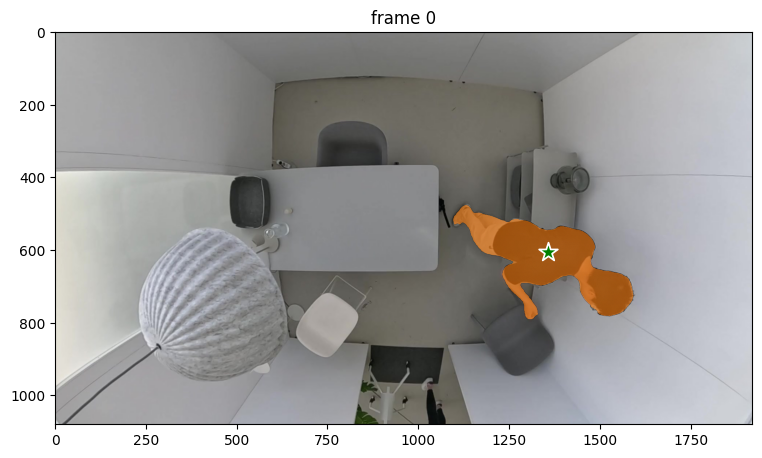

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (1000, 600) and a more positive click at (x, y) = (800, 400) to refine the mask
# TODO: change the points and labels to your own clicks
points = np.array([[1357, 604]], dtype=np.float32)
# for labels, `1` means positive click (what you want) and `0` means negative click (what you don't want)
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(VIDEO_FRAME_PATH, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

In [41]:
vis_frame_stride = 1
# video_segments = {}  # video_segments contains the per-frame segmentation results

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    # video_segments[out_frame_idx] = {
    #     out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
    #     for i, out_obj_id in enumerate(out_obj_ids)
    # }
    save_mask((out_mask_logits[0] > 0.0).cpu().numpy(), out_frame_idx, obj_id=out_obj_ids[0])
    save_center((out_mask_logits[0] > 0.0).cpu().numpy())   


propagate in video: 100%|██████████| 120/120 [00:13<00:00,  8.97it/s]


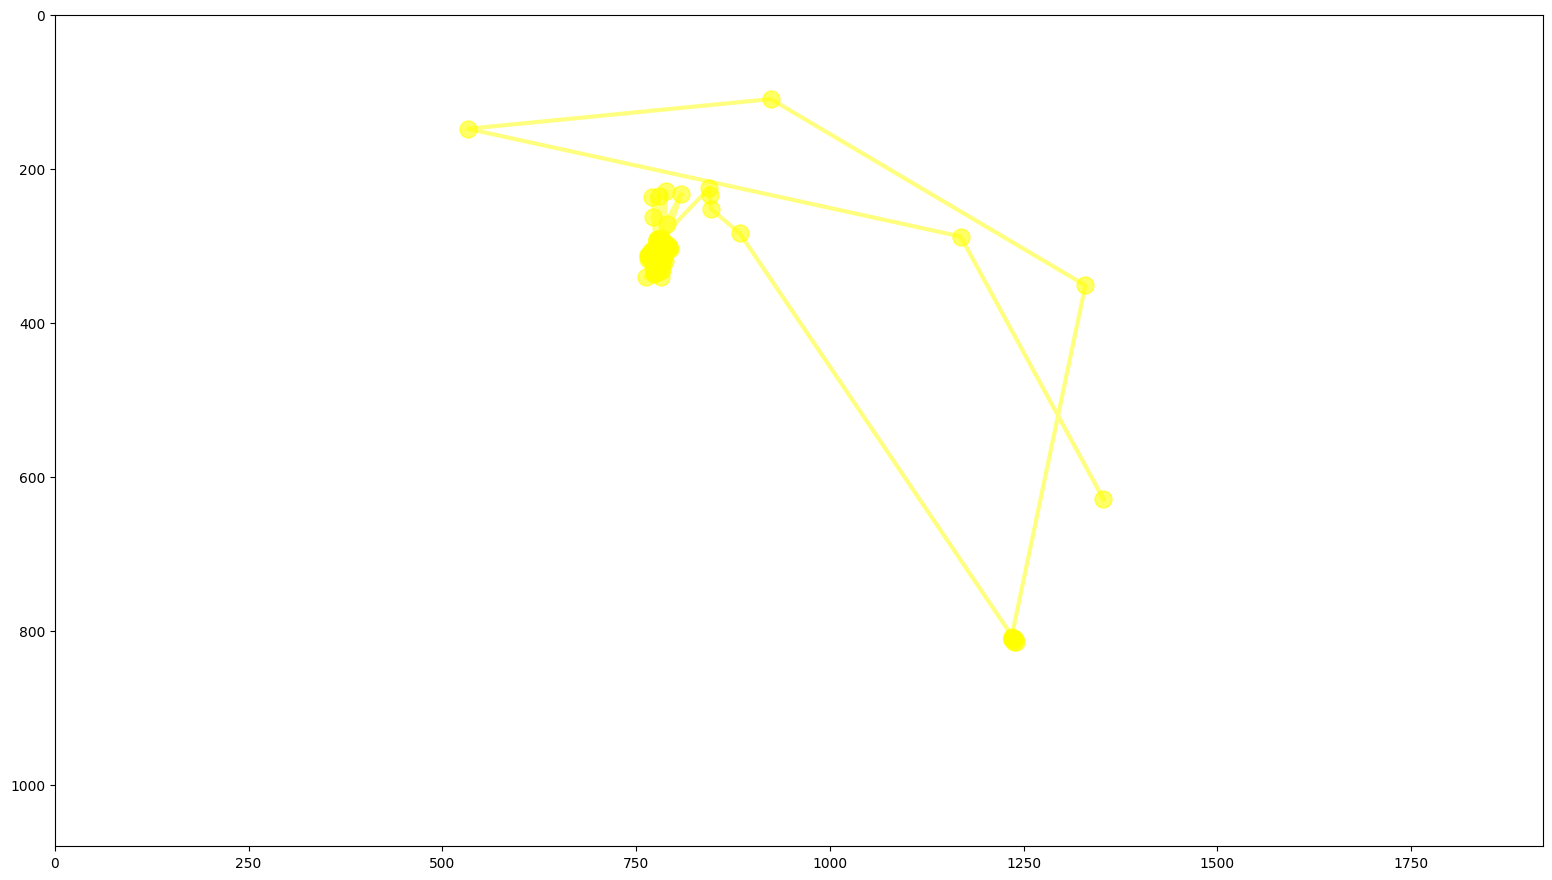

In [42]:
df = pd.read_csv(OUTPUT_TRAJECTORY_PATH)
df.columns = df.columns.str.strip()
df = replace_zero_coordinates(df)

x = df["x"].values
y = df["y"].values

# with interpolation, we can smooth the trajectory  
# t = np.linspace(0, len(x) - 1, 10000)  
# spl_x = make_interp_spline(range(len(x)), x, k=3)  
# spl_y = make_interp_spline(range(len(y)), y, k=3)  
# smooth_x = spl_x(t)
# smooth_y = spl_y(t)

fig, ax = plt.subplots(figsize=(19.2, 10.8))
ax.set_xlim(0, 1920)
ax.set_ylim(0, 1080)
ax.invert_yaxis()
plt.gca().set_facecolor((0, 0, 0, 0)) 
plt.plot(x, y, color="yellow", alpha=0.5, linewidth=3) 
plt.scatter(x, y, color="yellow", alpha=0.6, s=150) 
plt.savefig(OUTPUT_TRAJECTORY_IMAGE_PATH, format="png", transparent=True, bbox_inches="tight", pad_inches=0, dpi=300)
plt.savefig(OUTPUT_TRAJECTORY_PATH.replace(".csv", ".svg"), format="svg", transparent=True, bbox_inches="tight", pad_inches=0, dpi=300)
plt.savefig(OUTPUT_TRAJECTORY_PATH.replace(".csv", ".pdf"), format="pdf", transparent=True, bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()
plt.close()

In [ ]:
# old version of path drawing
# df = pd.read_csv(OUTPUT_TRAJECTORY_PATH)
# df.columns = df.columns.str.strip()
# df = replace_zero_coordinates(df)
# fig, ax = plt.subplots(figsize=(19.2, 10.8))
# ax.set_xlim(0, 1920)
# ax.set_ylim(0, 1080)
# ax.invert_yaxis()
# ax.imshow(Image.open(os.path.join(VIDEO_FRAME_PATH, frame_names[0])), extent=[0, 1920, 1080, 0])
# x = df['x']
# y = df['y']
# # check how many 0,0 points are there

# ax.plot(x, y , linestyle='-', color='blue', label= PROJECT_NAME)

# ax.set_title(PROJECT_NAME)
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.legend()
# plt.show()

# fig.savefig(OUTPUT_TRAJECTORY_PATH.replace(".csv", ".png")) 

In [43]:
# save the mask images to a video
# ffmpeg command to create a video from the mask images
# $ ffmpeg -framerate 1 -i happy%d.jpg -c:v libx264 -r 30 output.mp4

ffmpeg_command = [
    "ffmpeg",
    "-framerate", "29.97",
    "-i", f"{OUTPUT_MASK_PATH}/{frame_format}.jpg",
    "-c:v", "libx264",
    "-r", "29.97",
    OUTPUT_VIDEO_PATH
]

# run the ffmpeg command
subprocess.run(ffmpeg_command, check=True)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args=['ffmpeg', '-framerate', '29.97', '-i', 'results/7550_Neu_Edited_Object_Tracking_1_15fps/masks/%05d.jpg', '-c:v', 'libx264', '-r', '29.97', 'results/7550_Neu_Edited_Object_Tracking_1_15fps/videos/7550_Neu_Edited_Object_Tracking_1_15fps.mp4'], returncode=0)